# Generating parameter lists

# 1. Setup

In [1]:
%load_ext watermark
%load_ext autoreload

import glob
import copy
import pickle

import numpy as np
import pandas as pd
import xarray as xr

import scipy.stats as stats

import regionmask as rgn

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo

%watermark -iv -co -v

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

conda environment: cpl_ppe_co2

xarray    : 2024.6.0
scipy     : 1.14.0
cmocean   : 4.0.3
cartopy   : 0.24.1
numpy     : 2.0.1
regionmask: 0.12.1
pandas    : 2.2.2
sys       : 3.12.4 | packaged by conda-forge | (main, Jun 17 2024, 10:23:07) [GCC 12.3.0]
matplotlib: 3.9.1



## 1.1 Load color dictionaries

In [293]:
mpl.rcParams['figure.dpi'] = 150

with open('./top26_param_colors.pkl', 'rb') as f:
    pscs26_dict = pickle.load(f)
    pscs26 = list(pscs26_dict.values())

with open('./top12_param_colors.pkl', 'rb') as f:
    pscs12_dict = pickle.load(f)
    pscs12 = list(pscs12_dict.values())

## 1.2 Dask (if necessary)

# 2. Load data

## 2.1. Variable name

In [3]:
varname = 'EFLX_LH_TOT'

## 2.2 Master dataframe of CLM5 PPE rankings
`02_bgb_param-rank-diff-forc.ipynb`

In [4]:
clm5_rank = pd.read_csv(f'./rank/{varname}_params_rank_all.csv')
clm5_key = list(clm5_rank.columns[1:])

## 2.3 Daniel Kennedy's aggregated CLM5 PPE dataset

I used this dataset for converting the sparse grid to lat/lon grid

In [297]:
f = '/glade/u/home/djk2120/ppe_clean/postp/OAAT_surv.nc'
clm5 = xr.open_dataset(f)
clm5 = clm5[[s for s in list(clm5.keys()) if varname in s]]  # select variables with v in name

## 2.4. Gridded and atmos-feedback scaled CLM5 PPE
`03_bgb_expected-coupled-et.ipynb`
- need to check the global mean from my gridding vs. Daniel's aggregated dataset

In [5]:
indir = '/glade/work/bbuchovecky/CPL_PPE_CO2'

clm5_scaled = {
    'gr': xr.open_dataset(f'{indir}/select_parameters/{varname}_offline_gridded.nc'),
    'sc': xr.open_dataset(f'{indir}/select_parameters/{varname}_offline_scaled_gridded.nc'),
    'gr_zm': xr.open_dataset(f'{indir}/select_parameters/{varname}_offline_zonal.nc'),
    'sc_zm': xr.open_dataset(f'{indir}/select_parameters/{varname}_offline_scaled_zonal.nc'),
    # 'gr_gb': xr.open_dataset(f'{indir}/select_parameters/{varname}_offline_global.nc'),
    'sc_gb': xr.open_dataset(f'{indir}/select_parameters/{varname}_offline_scaled_global.nc'),
}

## 2.5. Transient CLM6 PPE
`04_bgb_transient-clm-ppe.ipynb`

In [6]:
# Load parameter settings key
clm6_key = pd.read_csv('/glade/campaign/cgd/tss/projects/PPE/ctsm6_oaat/ctsm6_oaat_key.csv')

# Load postprocessed temporally averaged dataset 
in_file = '/glade/campaign/cgd/tss/projects/PPE/ctsm6_oaat/postp/ctsm6_oaat_postp_1985-2023.nc'
clm6_tm = xr.open_dataset(in_file)

# Append key to ds
clm6_tm = clm6_tm.assign_coords(
    key=('ens', clm6_key['key'].values),
    param=('ens', clm6_key['param'].values),
    minmax=('ens', clm6_key['minmax'].values)
)
clm6_tm = clm6_tm.set_index(ens=['param', 'minmax', 'key'], append=True)
clm6_tm = clm6_tm[[v for v in clm6_tm.data_vars if v.startswith(varname)]]


# Load postprocessed timeseries dataset
in_file = '/glade/campaign/cgd/tss/projects/PPE/ctsm6_oaat/postp/ctsm6_oaat_postp_timeseries_1901-2023.nc'
clm6_ts = xr.open_dataset(in_file)

# Append key to ds
clm6_ts = clm6_ts.assign_coords(
    key=('ens', clm6_key['key'].values),
    param=('ens', clm6_key['param'].values),
    minmax=('ens', clm6_key['minmax'].values)
)
clm6_ts = clm6_ts.set_index(ens=['param', 'minmax', 'key'], append=True)
clm6_ts = clm6_ts[[v for v in clm6_ts.data_vars if v.startswith(varname)]]

## 2.6. ILAMB datasets
`process_ilamb.py`

`05_bgb_ILAMB-comparison.ipynb`

In [7]:
ilamb_varname = 'hfls'
indir = '/glade/work/bbuchovecky/CPL_PPE_CO2/select_parameters/ILAMB_data/processed'

# Zonal mean
ilamb_zm = xr.open_dataset(f'{indir}/zonal_mean/{ilamb_varname.upper()}_ZONAL_MEAN_ILAMB_2003-2009.nc')['et_itzavg_overlap']

# Global mean
ilamb_gm = {}
for f in sorted(glob.glob(indir + '/global_mean/*.nc')):
    key = f.split('/')[-1].split('_')[3]
    ilamb_gm[key] = xr.open_dataset(f)[ilamb_varname.lower()+'_'+key]

# 3. Functions

## 3.1 Set operations for master dataframe

In [10]:
def OR_top(df, rank, forc=None, biome=None, measure=None, do_diff_forc=False):
    '''
    Select parameters that appear in one of the top Y rank of mean and iav at the global and biome level.
    (effectively a union)
    '''
    forc_list = ['AF2095', 'AF1855', 'C867', 'C285']
    if do_diff_forc:
        forc_list = forc_list + ['AF2095-AF1855', 'C867-C285']
    biome_list = ['BF', 'SD', 'TmGD', 'TmRF', 'TmSF', 'TrRF', 'TrSFS', 'Tu', 'WS', 'GB']
    param = set()

    if forc is not None and biome is not None:
        if measure is None:
            param = set(df.loc[df[f'RNK_{forc}_{biome}_mean']<=rank]['param_name'].tolist())
            param = param | set(df.loc[df[f'RNK_{forc}_{biome}_iav']<=rank]['param_name'].tolist())
        else:
            param = set(df.loc[df[f'RNK_{forc}_{biome}_{measure}']<=rank]['param_name'].tolist())

    elif forc is not None and biome is None:
        for bm in biome_list:
            if measure is None:
                param = param | set(df.loc[df[f'RNK_{forc}_{bm}_mean']<=rank]['param_name'].tolist())
                param = param | set(df.loc[df[f'RNK_{forc}_{bm}_iav']<=rank]['param_name'].tolist())
            else:
                param = set(df.loc[df[f'RNK_{forc}_{bm}_{measure}']<=rank]['param_name'].tolist())
    
    elif biome is not None and forc is None:
        for fc in forc_list:
            if measure is None:
                param = param | set(df.loc[df[f'RNK_{fc}_{biome}_mean']<=rank]['param_name'].tolist())
                param = param | set(df.loc[df[f'RNK_{fc}_{biome}_iav']<=rank]['param_name'].tolist())
            else:
                param = set(df.loc[df[f'RNK_{fc}_{biome}_{measure}']<=rank]['param_name'].tolist())
            
    else:
        for fc in forc_list:
            for bm in biome_list:
                if measure is None:
                    param = param | set(df.loc[df[f'RNK_{fc}_{bm}_mean']<=rank]['param_name'].tolist())
                    param = param | set(df.loc[df[f'RNK_{fc}_{bm}_iav']<=rank]['param_name'].tolist())
                else:
                    param = set(df.loc[df[f'RNK_{fc}_{bm}_{measure}']<=rank]['param_name'].tolist())
                
    return df.loc[df['param_name'].isin(param)]


def AND_top(df, rank, forc=None, biome=None, measure=None, do_diff_forc=False):
    '''
    Select parameters that appear in every top Y rank of mean and iav at the global and biome level.
    (effectively an intersection)
    '''
    forc_list = ['AF2095', 'AF1855', 'C867', 'C285']
    if do_diff_forc:
        forc_list = forc_list + ['AF2095-AF1855', 'C867-C285']
    biome_list = ['BF', 'SD', 'TmGD', 'TmRF', 'TmSF', 'TrRF', 'TrSFS', 'Tu', 'WS', 'GB']
    param = set(df['param_name'].tolist())

    if forc is not None and biome is not None:
        if measure is None:
            param = set(df.loc[df[f'RNK_{forc}_{bm}_mean']<=rank]['param_name'].tolist())
            param = param & set(df.loc[df[f'RNK_{forc}_{bm}_iav']<=rank]['param_name'].tolist())
        else:
            param = param & set(df.loc[df[f'RNK_{forc}_{bm}_{measure}']<=rank]['param_name'].tolist())

    elif forc is not None and biome is None:
        for bm in biome_list:
            if measure is None:
                param = param & set(df.loc[df[f'RNK_{forc}_{bm}_mean']<=rank]['param_name'].tolist())
                param = param & set(df.loc[df[f'RNK_{forc}_{bm}_iav']<=rank]['param_name'].tolist())
            else:
                param = param & set(df.loc[df[f'RNK_{forc}_{bm}_{measure}']<=rank]['param_name'].tolist())
    
    elif biome is not None and forc is None:
        for fc in forc_list:
            if measure is None:
                param = param & set(df.loc[df[f'RNK_{fc}_{biome}_mean']<=rank]['param_name'].tolist())
                param = param & set(df.loc[df[f'RNK_{fc}_{biome}_iav']<=rank]['param_name'].tolist())
            else:
                param = param & set(df.loc[df[f'RNK_{fc}_{biome}_{measure}']<=rank]['param_name'].tolist())
            
    elif biome is None and forc is None:
        for fc in forc_list:
            for bm in biome_list:
                if measure is None:
                    param = param & set(df.loc[df[f'RNK_{fc}_{bm}_mean']<=rank]['param_name'].tolist())
                    param = param & set(df.loc[df[f'RNK_{fc}_{bm}_iav']<=rank]['param_name'].tolist())
                else:
                    param = param & set(df.loc[df[f'RNK_{fc}_{bm}_{measure}']<=rank]['param_name'].tolist())
                
    return df.loc[df['param_name'].isin(param)]

# 4. Plots

In [315]:
def plot_transient_ppe_with_ilamb(
    highlight_params=[],
    cs_clm6=[],
    vp_xpos = 2026,
    plot_ilamb=True,
    plot_ilamb_linear_regression = False,):
    '''
    Add docstring
    '''

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    if len(highlight_params) > 0:
        cs_ilamb = ['black']*len(ilamb_gm.keys())
    else:
        cs_ilamb = list(mpl.colors.TABLEAU_COLORS)

    # Plot all the CLM6 PPE ensemble members
    for i, e in enumerate(clm6_ts.ens):
        label = None
        if i == 0:
            label = 'CLM6 PPE'
        clm6_ts['EFLX_LH_TOT_global_mean'].sel(ens=e).plot(ax=ax, color='silver', alpha=0.5, lw=1, label=label, _labels=False)
    
    # Highlight the CLM6 default
    clm6_ts['EFLX_LH_TOT_global_mean'].sel(param='default', minmax='max').plot(ax=ax, color='k', lw=1, ls='-', label='CLM6 default', _labels=False)
    ax.scatter(
        vp_xpos+3,
        clm6_ts['EFLX_LH_TOT_global_mean'].sel(param='default', minmax='max').mean(dim='year'),
        s=15,
        marker='o',
        color='k',
    )

    # Plot the ILAMB datasets
    for i, (key, da) in enumerate(ilamb_gm.items()):
        label_ilamb = key
        ls_ilamb = '-'
        lw_ilamb = 1.5
        if len(highlight_params) > 0:
            label_ilamb = None
            ls_ilamb = (0, (5, 1))
            lw_ilamb = 1
            if i == 0:
                label_ilamb = 'ILAMB'
        if plot_ilamb:
            if plot_ilamb_linear_regression:
                lr = stats.linregress(da.year, da.values)
                ax.plot(da.year, lr.slope * da.year + lr.intercept, c=cs_ilamb[i], ls='--')
                print(f'{key}: m={lr.slope:.2f}, r={lr.rvalue:.2f}, p={lr.pvalue:.2f}')

            ax.plot(da.year, da, c=cs_ilamb[i], ls=ls_ilamb, lw=lw_ilamb, label=label_ilamb, zorder=100)
            ax.scatter(vp_xpos+3, da.mean(dim='year'), marker='o', s=15, edgecolor=cs_ilamb[i], facecolor='none')
        
        else:
            ax.scatter(vp_xpos+3, da.mean(dim='year'), marker='o', s=15, edgecolor=cs_ilamb[i], facecolor='none', label=label_ilamb)

    # Highlight the selected parameters
    if len(cs_clm6) == 0:
        cs_clm6 = ['tab:orange']*len(highlight_params)
    for i, p in enumerate(highlight_params):
        for m, mk in zip(['min', 'max'], ['o', 'D']):
            if m == 'min':
                label_clm6 = p
            else:
                label_clm6 = None
            clm6_ts['EFLX_LH_TOT_global_mean'].sel(param=p, minmax=m).plot(ax=ax, color=cs_clm6[i], lw=1.5, ls='-', label=label_clm6, _labels=False)
            ax.scatter(
                vp_xpos+5,
                clm6_ts['EFLX_LH_TOT_global_mean'].sel(param=p, minmax=m).mean(dim='year'),
                s=10,
                marker=mk,
                color=cs_clm6[i],
            )

    # Add a violin plot for the time average of the CLM6 PPE ensemble
    vp = ax.violinplot(
        clm6_ts['EFLX_LH_TOT_global_mean'].mean(dim='year'),
        [vp_xpos],
        vert=True,
        widths=15,
        side='high',
        showmeans=False,
        showextrema=True,
        showmedians=True,
    )
    vp['bodies'][0].set(facecolor='gray')
    vp['cbars'].set(linewidth=0)
    vp['cmedians'].set(linewidth=1, color='dimgray')
    vp['cmins'].set(linewidth=1, color='dimgray')
    vp['cmaxes'].set(linewidth=1, color='dimgray')

    segmed = vp['cmedians'].get_segments().copy()
    segmin = vp['cmins'].get_segments().copy()
    segmax = vp['cmaxes'].get_segments().copy()
    for smed, smin, smax in zip(segmed, segmin, segmax):
        for s in [smed, smin, smax]:
            s[0][0] = vp_xpos - 1
            s[1][0] = vp_xpos + 1
    vp['cmedians'].set_segments(segmed)
    vp['cmins'].set_segments(segmin)
    vp['cmaxes'].set_segments(segmax)

    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='y', labelright=True)

    ax.legend(loc='lower left', ncol=2, fontsize=8)
    ax.set_title('global mean latent heat flux: transient CLM6 PPE and ILAMB datasets', loc='left', fontsize=10)
    ax.set_ylabel('latent heat flux [W m$^{-2}$]')
    ax.set_xlabel('year')
    ax.set_xlim(1898, 2035)

    return fig, ax

In [309]:
np.unique(clm6_ts['EFLX_LH_TOT_global_mean'].param)

array(['ACCLIM_SF', 'FUN_fracfixers', 'KCN', 'RF_CWD', 'RF_LS', 'RF_SS',
       'TAU', 'accum_factor', 'baseflow_scalar', 'bsw_sf',
       'crit_onset_gdd_sf', 'cv', 'd_max', 'decomp_depth_efolding',
       'default', 'dleaf', 'e_ice', 'fff', 'froot_leaf', 'fsr_pft',
       'fstor2tran', 'grperc', 'hksat_sf', 'interception_fraction',
       'jmaxb0', 'jmaxb1', 'jmaxha', 'kmax', 'leaf_long', 'leafcn',
       'lmr_intercept_atkin', 'lmrha', 'lmrse',
       'maximum_leaf_wetted_fraction', 'maxpsi_hr', 'medlynintercept',
       'medlynslope', 'minpsi_hr', 'n_melt_coef', 'nfix_tmax',
       'nfix_tmin', 'nfix_topt', 'om_frac_sf', 'pot_hmn_ign_counts_alpha',
       'psi50', 'q10_mr', 'r_mort', 'slatop', 'snw_rds_refrz',
       'sucsat_sf', 'theta_cj', 'tpu25ratio', 'tpuha',
       'upplim_destruct_metamorph', 'vcmaxha', 'watsat_sf', 'wc2wjb0',
       'xdrdt', 'xl', 'z0v_Cr', 'z0v_Cs', 'z0v_c', 'z0v_cw'], dtype=object)

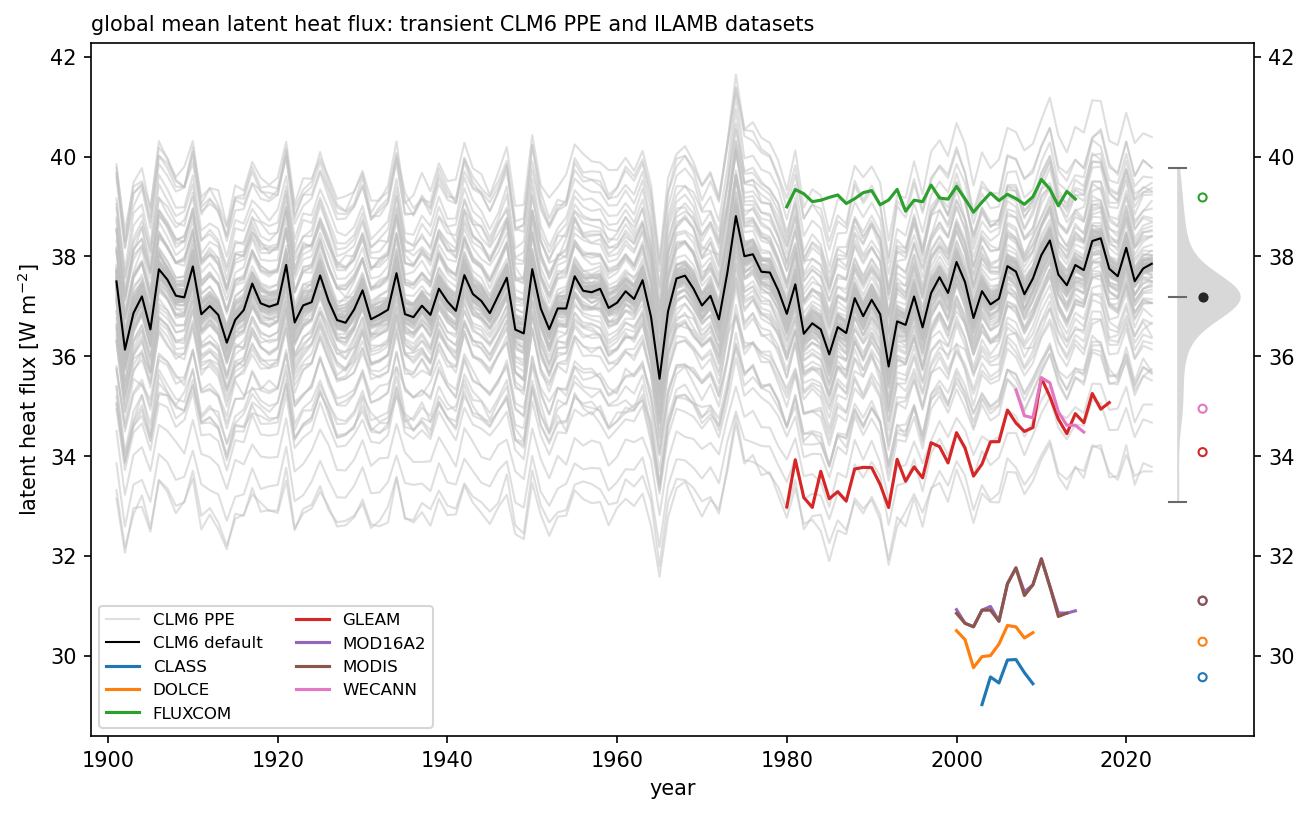

In [318]:
fig, ax = plot_transient_ppe_with_ilamb()
fig.savefig('./ilamb/transient_clm6_ppe_ilamb.png', bbox_inches='tight', dpi=400)

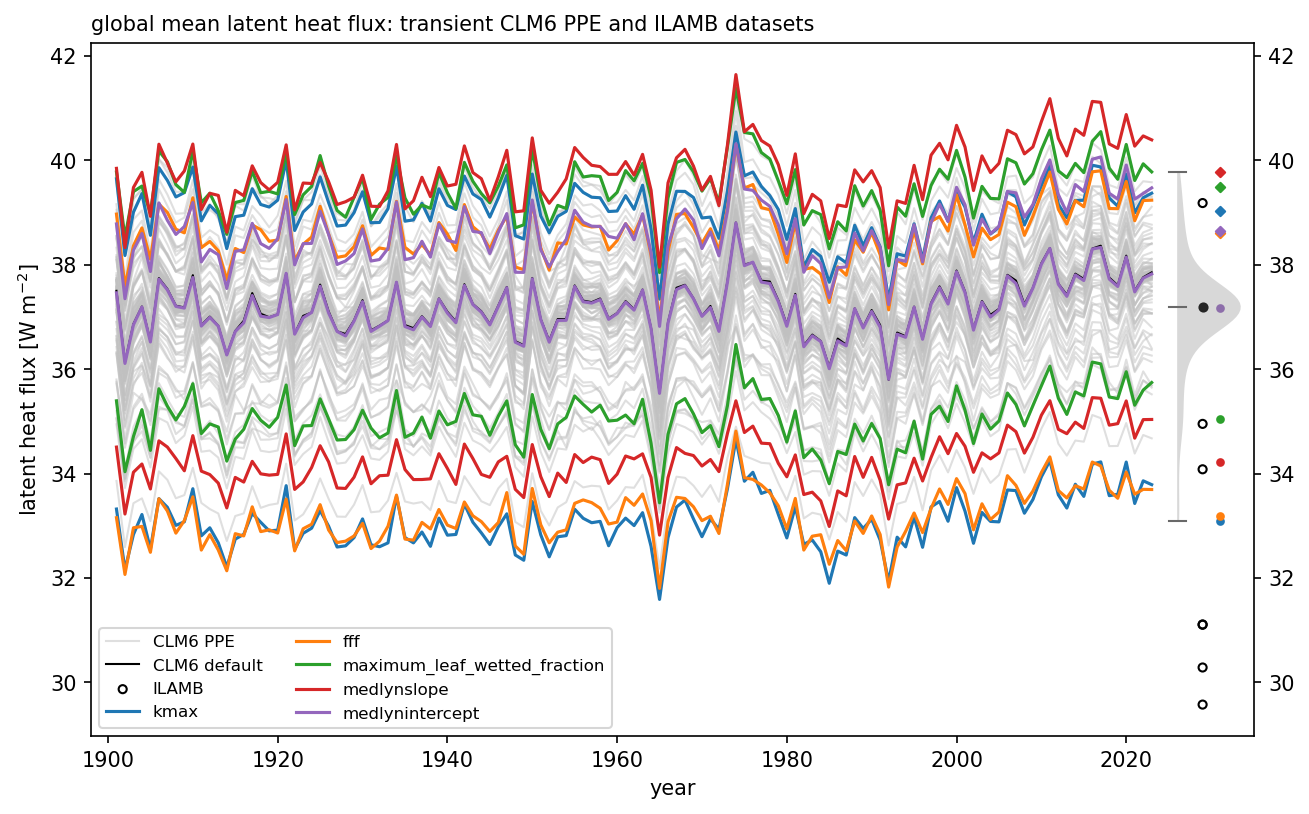

In [319]:
fig, ax = plot_transient_ppe_with_ilamb(
    ['kmax', 'fff', 'maximum_leaf_wetted_fraction', 'medlynslope', 'medlynintercept'],
    list(mpl.colors.TABLEAU_COLORS),
    plot_ilamb=False,
)
fig.savefig('./ilamb/transient_clm6_ppe_ilamb_highlight_params.png', bbox_inches='tight', dpi=400)

Text(0.5, 0, 'year')

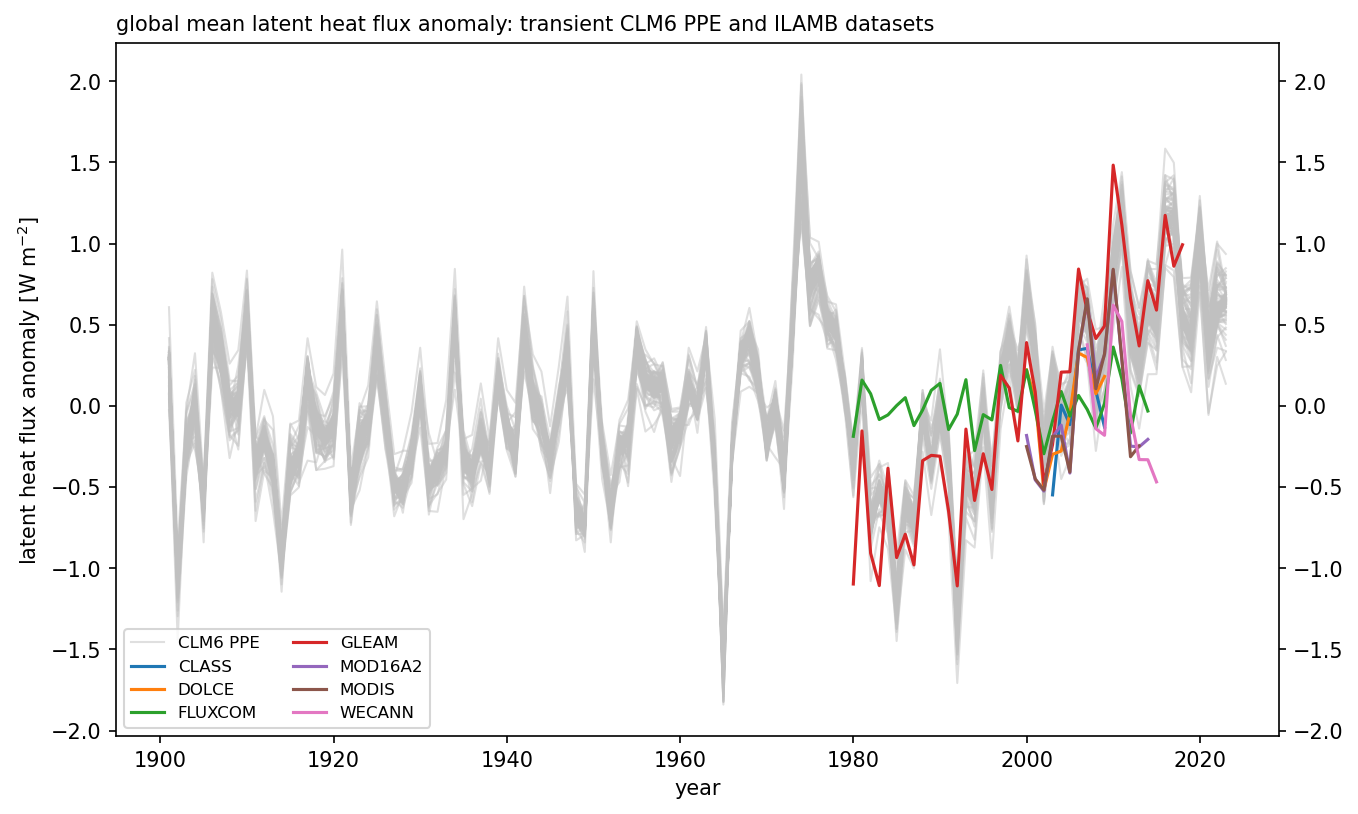

In [271]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
cs = list(mpl.colors.TABLEAU_COLORS)

for i, e in enumerate(clm6_ts.ens):
    label = None
    if i == 0:
        label = 'CLM6 PPE'
    (clm6_ts['EFLX_LH_TOT_global_mean'].sel(ens=e) - clm6_ts['EFLX_LH_TOT_global_mean'].sel(ens=e).mean(dim='year')).plot(ax=ax, color='silver', alpha=0.5, lw=1, label=label, _labels=False)

for i, (key, da) in enumerate(ilamb_gm.items()):
    lr = stats.linregress(da.year, da.values)
    ax.plot(da.year, da - da.mean(dim='year'), c=cs[i], label=f'{key}')

ax.yaxis.set_ticks_position('both')
ax.tick_params(axis='y', labelright=True)

ax.legend(loc='lower left', ncol=2, fontsize=8)
ax.set_title('global mean latent heat flux anomaly: transient CLM6 PPE and ILAMB datasets', loc='left', fontsize=10)
ax.set_ylabel('latent heat flux anomaly [W m$^{-2}$]')
ax.set_xlabel('year')

# 5. Parameter lists